 10-dimensional Q matrix with condition number: 10.00
Starting 10 runs for statistical analysis (D=10, Cond=10.0, Target Loss < 1e-06)...
Run 2/10 completed.
Run 4/10 completed.
Run 6/10 completed.
Run 8/10 completed.
Run 10/10 completed.

--- Summary of Results (Mean $\pm$ Std Iterations) ---
MSAM: 2483 $\pm$ 410
Adam: 5626 $\pm$ 921
AdaDelta: 69219 $\pm$ 9123
SGD-Momentum: 6589 $\pm$ 565


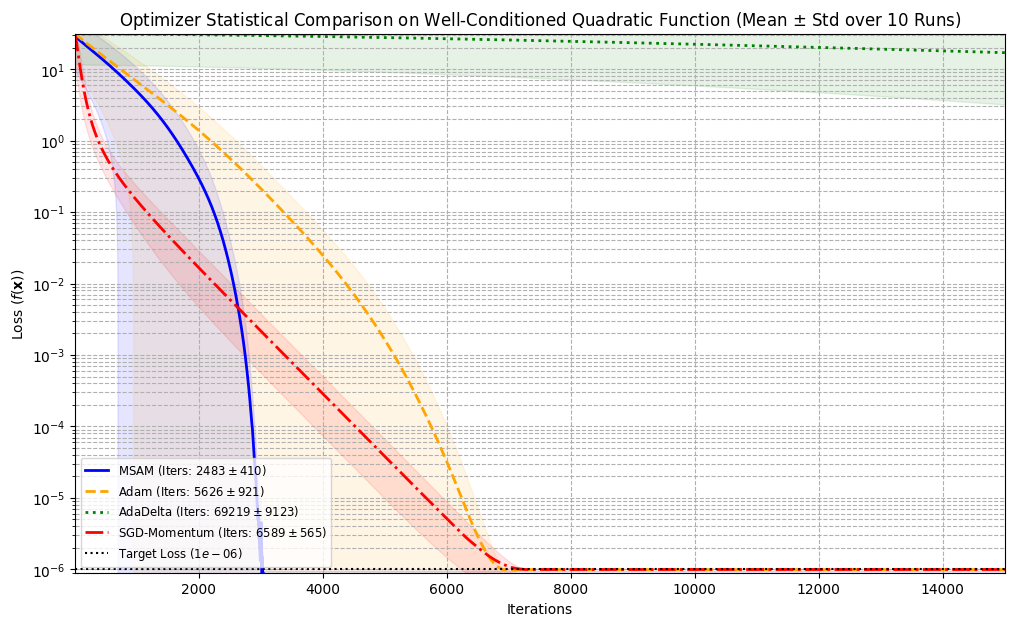

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global Configuration ---
# Setting a seed for reproducibility of the Q_MATRIX, but the starting vector X0 will change per run.
# The seed for the starting vector X0 is set inside the loop for each run.
np.random.seed(0) 

# Optimizer Hyperparameters
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999)
ADAM_DEFAULT_EPS = 1e-7 

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# Problem Parameters
DIMENSION = 10
CONDITION_NUMBER = 10.0
TARGET_LOSS = 1e-6
MAX_ITERS = 200000 
NUM_RUNS = 10 # Number of statistical runs

# --- Problem Setup Functions ---
def create_quadratic_problem(dim, condition_num):
    s_max = condition_num
    s_min = 1.0 
    
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

def quadratic_function_high_dim(x):
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    return Q_MATRIX @ x

# --- Optimizer Setup Functions (Unchanged) ---
def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        # m_new is the uncorrected first moment of m
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # In RMSM/MSAM, the second moment is for m_new squared
        m_squared = m_new**2 
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        # Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2) # Adam uses grad**2
        
        # Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adadelta(lr, dim, **kwargs):
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim) # Exponential average of squared gradients
    Ex_squared = np.zeros(dim) # Exponential average of squared updates
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        
        # Calculate Eg_squared_new
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        
        # Calculate update step scale based on RMS of previous updates and current gradients
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        
        # Calculate Ex_squared_new
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        # In Adadelta, the effective LR is 1.0, but we pass the LR parameter for consistency
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim)
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + (1.0 - momentum) * grad
        v = v_new
        
        return x - lr * v_new
    return update

# --- Modified Optimization Run for Statistical Analysis ---
def optimization_run_stat(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):

    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        loss_history.append(loss)

        if loss < target_loss:
            # Pad the remaining history with the final loss for consistent array length
            final_loss = loss
            iterations_to_pad = max_iters - (iteration + 1)
            if iterations_to_pad > 0:
                loss_history.extend([final_loss] * iterations_to_pad)
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        x = optimizer_update_func(x, grad)

    # If it finishes all iterations without reaching the goal, the history is MAX_ITERS long
    return max_iters, loss_history


# --- Statistical Analysis Loop ---

all_loss_histories = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}
all_final_iterations = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}

print(f"Starting {NUM_RUNS} runs for statistical analysis (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})...")

for run in range(NUM_RUNS):
    # Set a unique seed for the starting vector X0 for each run
    # This ensures a different random starting point for each iteration of the statistical analysis
    np.random.seed(run + 1) 
    X0_run = np.random.randn(DIMENSION)

    # --- Run Optimizers ---
    
    # MSAM
    iters, history = optimization_run_stat(setup_msam, "MSAM", CUSTOM_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=CUSTOM_BETAS, eps=CUSTOM_EPS)
    all_final_iterations['MSAM'].append(iters)
    all_loss_histories['MSAM'].append(history)

    # Adam
    iters, history = optimization_run_stat(setup_adam, "Adam", ADAM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS)
    all_final_iterations['Adam'].append(iters)
    all_loss_histories['Adam'].append(history)

    # AdaDelta
    iters, history = optimization_run_stat(setup_adadelta, "AdaDelta", ADADELTA_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS)
    all_final_iterations['AdaDelta'].append(iters)
    all_loss_histories['AdaDelta'].append(history)

    # SGD-Momentum
    iters, history = optimization_run_stat(setup_sgd_momentum, "SGD-Momentum", SGD_MOM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, momentum=SGD_MOM_DEFAULT_MOMENTUM)
    all_final_iterations['SGD-Momentum'].append(iters)
    all_loss_histories['SGD-Momentum'].append(history)

    if (run + 1) % 2 == 0:
        print(f"Run {run+1}/{NUM_RUNS} completed.")


# --- Calculate Statistics ---

mean_loss = {}
std_loss = {}
mean_iters = {}
std_iters = {}
optimizer_names = ['MSAM', 'Adam', 'AdaDelta', 'SGD-Momentum']

for name in optimizer_names:
    histories_array = np.array(all_loss_histories[name])
    
    # Calculate mean and std deviation of loss over the runs (axis=0)
    mean_loss[name] = np.mean(histories_array, axis=0)
    std_loss[name] = np.std(histories_array, axis=0)

    # Calculate mean and std deviation for iterations
    mean_iters[name] = np.mean(all_final_iterations[name])
    std_iters[name] = np.std(all_final_iterations[name])


# --- Plotting ---

plt.figure(figsize=(12, 7))

# Plot parameters
colors = {'MSAM': 'blue', 'Adam': 'orange', 'AdaDelta': 'green', 'SGD-Momentum': 'red'}
linestyles = {'MSAM': '-', 'Adam': '--', 'AdaDelta': ':', 'SGD-Momentum': '-.'}

x_axis = np.arange(1, MAX_ITERS + 1)

for name in optimizer_names:
    mean = mean_loss[name]
    std = std_loss[name]
    color = colors[name]
    
    # Create the label with mean +/- std iterations
    label = f"{name} (Iters: ${mean_iters[name]:.0f} \\pm {std_iters[name]:.0f}$)"
    
    # Plot mean loss
    plt.plot(x_axis, mean, 
             label=label, 
             linestyle=linestyles[name], 
             linewidth=2, 
             color=color)
    
    # Plot shaded region for mean +/- std
    plt.fill_between(x_axis, mean - std, mean + std, 
                     color=color, alpha=0.1)


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss (${TARGET_LOSS:.0e}$)')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Statistical Comparison on Well-Conditioned Quadratic Function (Mean $\\pm$ Std over {NUM_RUNS} Runs)")
plt.legend(loc='lower left', fontsize='small')
plt.yscale('log')
# Zoom in on the x-axis to clearly show the convergence phase
plt.xlim(1, 15000) 
plt.ylim(TARGET_LOSS * 0.9, np.max(mean_loss['SGD-Momentum'][:15000]))
plt.grid(True, which="both", ls="--")
plt.savefig('optimizer_stat_comparison.png')

print("\n--- Summary of Results (Mean $\\pm$ Std Iterations) ---")
for name in optimizer_names:
    print(f"{name}: {mean_iters[name]:.0f} $\\pm$ {std_iters[name]:.0f}")

 10-dimensional Q matrix with condition number: 50.00

Starting 10 runs for statistical analysis (D=10, Cond=50.0, Target Loss < 1e-06)...
Run 2/10 completed.
Run 4/10 completed.
Run 6/10 completed.
Run 8/10 completed.
Run 10/10 completed.

--- Summary of Results (Mean $\pm$ Std Iterations) ---
MSAM: 2540 $\pm$ 412
Adam: 2567 $\pm$ 407
AdaDelta: 20000 $\pm$ 0
SGD-Momentum: 19646 $\pm$ 1062


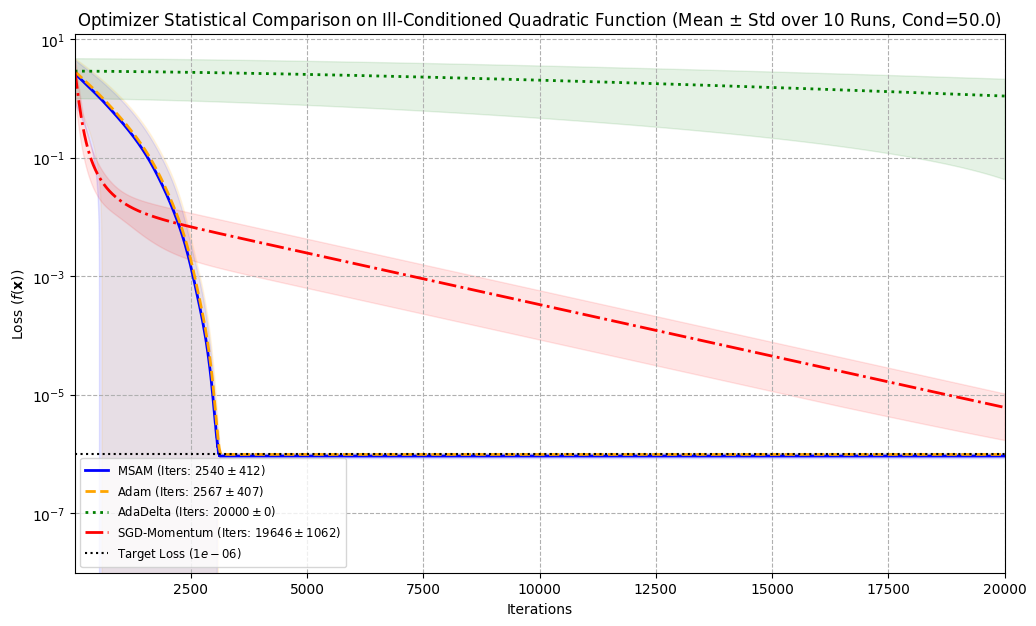

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global Configuration ---
np.random.seed(0) 

# Optimizer Hyperparameters
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8 

ADADELTA_DEFAULT_LR = 0.001 
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# Problem Parameters
DIMENSION = 10
CONDITION_NUMBER = 50.0 # ILL-CONDITIONED
TARGET_LOSS = 1e-6
MAX_ITERS = 20000 
NUM_RUNS = 10 # Number of statistical runs

# --- Problem Setup Functions ---
def create_quadratic_problem(dim, condition_num):
    s_max = 1.0
    s_min = s_max / condition_num
    
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

def quadratic_function_high_dim(x):
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    return Q_MATRIX @ x

# X0 is no longer generated here; it's generated inside the loop.

# --- Optimizer Setup Functions ---
# (MSAM, Adam, AdaDelta, SGD-Momentum setup functions remain as provided by the user)

def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adadelta(lr, dim, **kwargs):
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim) 
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + lr * grad
        v = v_new
        return x - v_new
    return update


# --- Modified Optimization Run for Statistical Analysis ---
def optimization_run_stat(optimizer_setup, lr, initial_x, target_loss, max_iters, **kwargs):

    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        loss_history.append(loss)

        if loss < target_loss:
            # Pad the remaining history with the final loss for consistent array length
            final_loss = loss
            iterations_to_pad = max_iters - (iteration + 1)
            if iterations_to_pad > 0:
                loss_history.extend([final_loss] * iterations_to_pad)
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        x = optimizer_update_func(x, grad)

    # If it finishes all iterations without reaching the goal
    return max_iters, loss_history


# --- Statistical Analysis Loop ---

all_loss_histories = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}
all_final_iterations = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}
optimizer_names = ['MSAM', 'Adam', 'AdaDelta', 'SGD-Momentum']

print(f"\nStarting {NUM_RUNS} runs for statistical analysis (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})...")

for run in range(NUM_RUNS):
    # Set a unique seed for the starting vector X0 for each run
    np.random.seed(run + 1) 
    X0_run = np.random.randn(DIMENSION)

    # --- Run Optimizers ---
    
    # MSAM
    iters, history = optimization_run_stat(setup_msam, CUSTOM_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=CUSTOM_BETAS, eps=CUSTOM_EPS)
    all_final_iterations['MSAM'].append(iters)
    all_loss_histories['MSAM'].append(history)

    # Adam
    iters, history = optimization_run_stat(setup_adam, ADAM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS)
    all_final_iterations['Adam'].append(iters)
    all_loss_histories['Adam'].append(history)

    # AdaDelta
    iters, history = optimization_run_stat(setup_adadelta, ADADELTA_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS)
    all_final_iterations['AdaDelta'].append(iters)
    all_loss_histories['AdaDelta'].append(history)

    # SGD-Momentum
    iters, history = optimization_run_stat(setup_sgd_momentum, SGD_MOM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, momentum=SGD_MOM_DEFAULT_MOMENTUM)
    all_final_iterations['SGD-Momentum'].append(iters)
    all_loss_histories['SGD-Momentum'].append(history)

    if (run + 1) % 2 == 0:
        print(f"Run {run+1}/{NUM_RUNS} completed.")


# --- Calculate Statistics ---

mean_loss = {}
std_loss = {}
mean_iters = {}
std_iters = {}

for name in optimizer_names:
    histories_array = np.array(all_loss_histories[name])
    
    # Calculate mean and std deviation of loss over the runs (axis=0)
    mean_loss[name] = np.mean(histories_array, axis=0)
    std_loss[name] = np.std(histories_array, axis=0)

    # Calculate mean and std deviation for iterations
    mean_iters[name] = np.mean(all_final_iterations[name])
    std_iters[name] = np.std(all_final_iterations[name])


# --- Plotting ---

plt.figure(figsize=(12, 7))

# Plot parameters
colors = {'MSAM': 'blue', 'Adam': 'orange', 'AdaDelta': 'green', 'SGD-Momentum': 'red'}
linestyles = {'MSAM': '-', 'Adam': '--', 'AdaDelta': ':', 'SGD-Momentum': '-.'}

x_axis = np.arange(1, MAX_ITERS + 1)

for name in optimizer_names:
    mean = mean_loss[name]
    std = std_loss[name]
    color = colors[name]
    
    # Create the label with mean +/- std iterations
    label = f"{name} (Iters: ${mean_iters[name]:.0f} \\pm {std_iters[name]:.0f}$)"
    
    # Plot mean loss
    plt.plot(x_axis, mean, 
             label=label, 
             linestyle=linestyles[name], 
             linewidth=2, 
             color=color)
    
    # Plot shaded region for mean +/- std
    plt.fill_between(x_axis, mean - std, mean + std, 
                     color=color, alpha=0.1)


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss (${TARGET_LOSS:.0e}$)')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Statistical Comparison on Ill-Conditioned Quadratic Function (Mean $\\pm$ Std over {NUM_RUNS} Runs, Cond={CONDITION_NUMBER:.1f})")
plt.legend(loc='lower left', fontsize='small')
plt.yscale('log')
plt.xlim(1, MAX_ITERS) 
plt.grid(True, which="both", ls="--")
plt.savefig('optimizer_stat_comparison_ill_cond.png')

print("\n--- Summary of Results (Mean $\\pm$ Std Iterations) ---")
for name in optimizer_names:
    print(f"{name}: {mean_iters[name]:.0f} $\\pm$ {std_iters[name]:.0f}")

Starting 10 runs for Rosenbrock analysis (Target Loss < 1e-04)...
Run 2/10 completed.
Run 4/10 completed.


C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:34: RuntimeWarning: overflow encountered in scalar power
  return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:37: RuntimeWarning: overflow encountered in scalar multiply
  grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:108: RuntimeWarning: invalid value encountered in add
  v_new = momentum * v + lr * grad


Run 6/10 completed.


C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:37: RuntimeWarning: overflow encountered in scalar power
  grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:38: RuntimeWarning: overflow encountered in scalar power
  grad_y = 200.0 * (x[1] - x[0]**2)
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:34: RuntimeWarning: invalid value encountered in scalar subtract
  return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:37: RuntimeWarning: invalid value encountered in scalar subtract
  grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
C:\Users\ymant\AppData\Local\Temp\ipykernel_30900\1088935939.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  grad_y = 200.0 * (x[1] - x[0]**2)


Run 8/10 completed.
Run 10/10 completed.


c:\Users\ymant\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



--- Summary of Results (Mean $\pm$ Std Iterations) ---
MSAM: 3222 $\pm$ 1010
Adam: 3260 $\pm$ 1001
AdaDelta: 20000 $\pm$ 0
SGD-Momentum: 6623 $\pm$ 8758


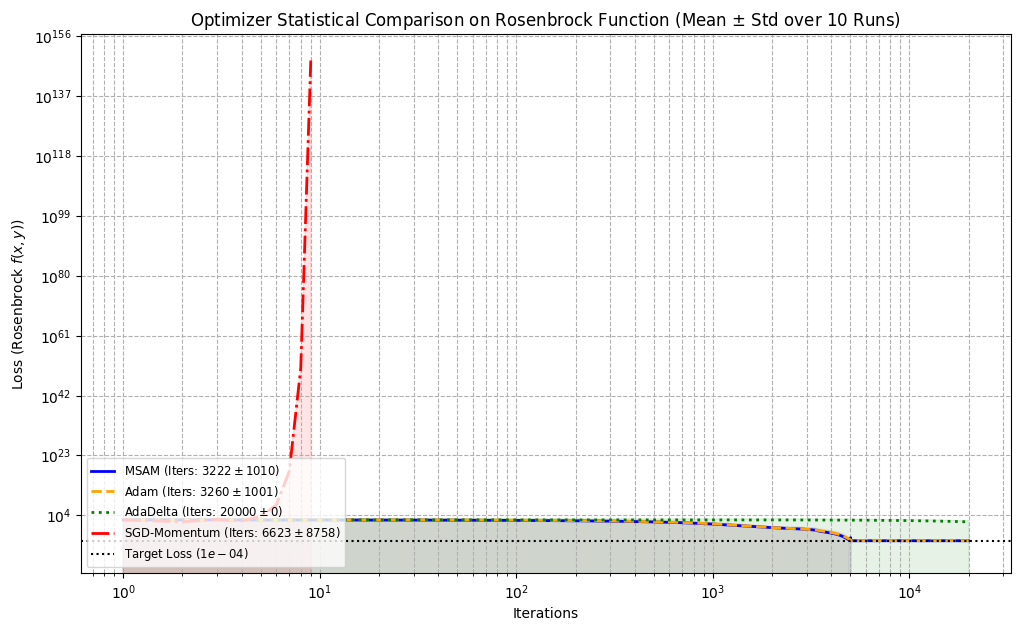

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global Configuration ---
# Setting a seed for general reproducibility, but X0 is randomized per run below.
np.random.seed(42) 

# Optimizer Hyperparameters
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8 

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# Problem Parameters
DIMENSION = 2
TARGET_LOSS = 1e-4
MAX_ITERS = 20000 
NUM_RUNS = 10 # Number of statistical runs
X_START_RANGE = 2.0 # Starting points will be generated in [-2, 2]

# --- Rosenbrock Functions ---
def rosenbrock_function(x):
    # Global minimum f(1, 1) = 0
    return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

def rosenbrock_gradient(x):
    grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    grad_y = 200.0 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])

# --- Optimizer Setup Functions ---
# (Using the user-provided setup functions for MSAM, Adam, AdaDelta, SGD-Momentum)

def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adadelta(lr, dim, **kwargs):
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim) 
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + lr * grad
        v = v_new
        return x - v_new
    return update

# --- Modified Optimization Run for Statistical Analysis ---
def optimization_run_stat(optimizer_setup, lr, initial_x, target_loss, max_iters, **kwargs):
    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []

    for iteration in range(max_iters):
        loss = rosenbrock_function(x)
        loss_history.append(loss)

        if loss < target_loss:
            # Pad the remaining history with the final loss for consistent array length
            final_loss = loss
            iterations_to_pad = max_iters - (iteration + 1)
            if iterations_to_pad > 0:
                loss_history.extend([final_loss] * iterations_to_pad)
            return iteration + 1, loss_history

        grad = rosenbrock_gradient(x)
        x = optimizer_update_func(x, grad)

    # If it finishes all iterations without reaching the goal
    return max_iters, loss_history


# --- Statistical Analysis Loop ---

all_loss_histories = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}
all_final_iterations = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}
optimizer_names = ['MSAM', 'Adam', 'AdaDelta', 'SGD-Momentum']

print(f"Starting {NUM_RUNS} runs for Rosenbrock analysis (Target Loss < {TARGET_LOSS:.0e})...")

for run in range(NUM_RUNS):
    # Set a unique seed for the starting vector X0 for each run
    np.random.seed(run + 100) # Use a different seed sequence than the previous analysis
    
    # Generate a random starting point in the range [-X_START_RANGE, X_START_RANGE]
    X0_run = np.random.uniform(-X_START_RANGE, X_START_RANGE, size=DIMENSION)

    # --- Run Optimizers ---
    
    # MSAM
    iters, history = optimization_run_stat(setup_msam, CUSTOM_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=CUSTOM_BETAS, eps=CUSTOM_EPS)
    all_final_iterations['MSAM'].append(iters)
    all_loss_histories['MSAM'].append(history)

    # Adam
    iters, history = optimization_run_stat(setup_adam, ADAM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS)
    all_final_iterations['Adam'].append(iters)
    all_loss_histories['Adam'].append(history)

    # AdaDelta
    iters, history = optimization_run_stat(setup_adadelta, ADADELTA_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS)
    all_final_iterations['AdaDelta'].append(iters)
    all_loss_histories['AdaDelta'].append(history)

    # SGD-Momentum
    iters, history = optimization_run_stat(setup_sgd_momentum, SGD_MOM_DEFAULT_LR, X0_run, TARGET_LOSS, MAX_ITERS, momentum=SGD_MOM_DEFAULT_MOMENTUM)
    all_final_iterations['SGD-Momentum'].append(iters)
    all_loss_histories['SGD-Momentum'].append(history)

    if (run + 1) % 2 == 0:
        print(f"Run {run+1}/{NUM_RUNS} completed.")


# --- Calculate Statistics ---

mean_loss = {}
std_loss = {}
mean_iters = {}
std_iters = {}

for name in optimizer_names:
    histories_array = np.array(all_loss_histories[name])
    
    # Calculate mean and std deviation of loss over the runs (axis=0)
    mean_loss[name] = np.mean(histories_array, axis=0)
    std_loss[name] = np.std(histories_array, axis=0)

    # Calculate mean and std deviation for iterations
    mean_iters[name] = np.mean(all_final_iterations[name])
    std_iters[name] = np.std(all_final_iterations[name])


# --- Plotting ---

plt.figure(figsize=(12, 7))

# Plot parameters
colors = {'MSAM': 'blue', 'Adam': 'orange', 'AdaDelta': 'green', 'SGD-Momentum': 'red'}
linestyles = {'MSAM': '-', 'Adam': '--', 'AdaDelta': ':', 'SGD-Momentum': '-.'}

x_axis = np.arange(1, MAX_ITERS + 1)

for name in optimizer_names:
    mean = mean_loss[name]
    std = std_loss[name]
    color = colors[name]
    
    # Create the label with mean +/- std iterations
    label = f"{name} (Iters: ${mean_iters[name]:.0f} \\pm {std_iters[name]:.0f}$)"
    
    # Plot mean loss
    plt.plot(x_axis, mean, 
             label=label, 
             linestyle=linestyles[name], 
             linewidth=2, 
             color=color)
    
    # Plot shaded region for mean +/- std
    plt.fill_between(x_axis, mean - std, mean + std, 
                     color=color, alpha=0.1)


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss (${TARGET_LOSS:.0e}$)')
plt.xlabel("Iterations")
plt.ylabel("Loss (Rosenbrock $f(x,y)$)")
plt.title(f"Optimizer Statistical Comparison on Rosenbrock Function (Mean $\\pm$ Std over {NUM_RUNS} Runs)")
plt.legend(loc='lower left', fontsize='small')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.savefig('rosenbrock_stat_comparison.png')

print("\n--- Summary of Results (Mean $\\pm$ Std Iterations) ---")
for name in optimizer_names:
    print(f"{name}: {mean_iters[name]:.0f} $\\pm$ {std_iters[name]:.0f}")

Starting 5 runs for MNIST classification over 10 epochs each...
Run 1/5 completed.
Run 2/5 completed.
Run 3/5 completed.
Run 4/5 completed.
Run 5/5 completed.


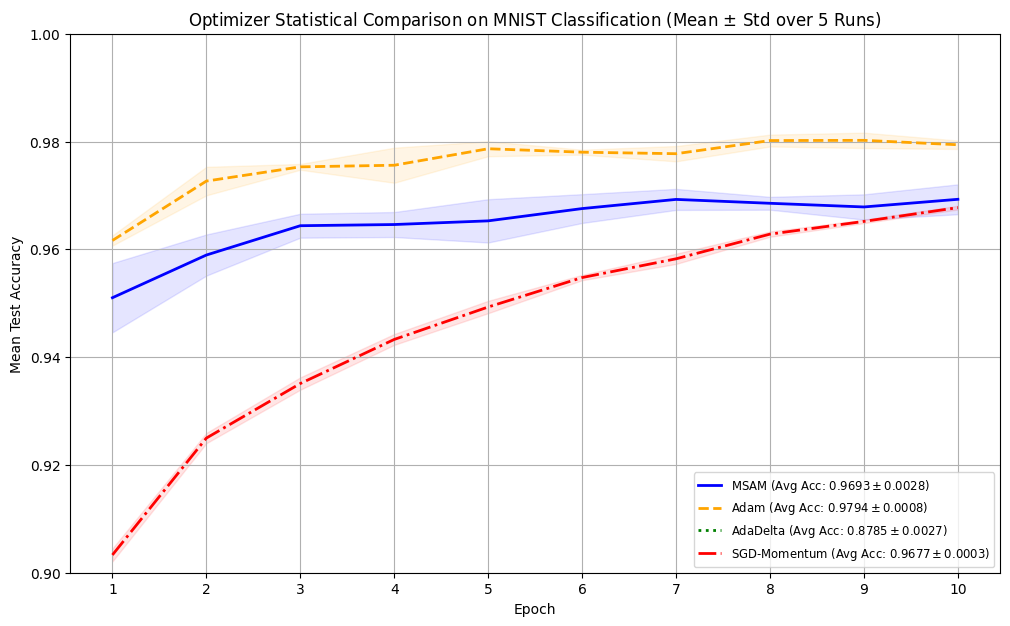


--- Summary of Results (Mean $\pm$ Std Final Test Accuracy) ---
MSAM: 0.9693 $\pm$ 0.0028
Adam: 0.9794 $\pm$ 0.0008
AdaDelta: 0.8785 $\pm$ 0.0027
SGD-Momentum: 0.9677 $\pm$ 0.0003


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 64
NUM_RUNS = 5 

# Optimizer Hyperparameters
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# --- MSAM Optimizer Implementation ---
class MSAM(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(MSAM, self).__init__(params, defaults)
        self.iterations = 0

    @torch.no_grad()
    def step(self):
        self.iterations += 1
        
        for group in self.param_groups:
            lr, beta1, beta2 = group["lr"], group["betas"][0], group["betas"][1]
            eps = group["eps"]
            t = self.iterations

            denom_b1 = 1.0 - beta1 ** t
            denom_b2 = 1.0 - beta2 ** t
            
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad.float() # Ensure gradient is float
                state = self.state[p]

                # State initialization
                if "m" not in state:
                    state["m"] = torch.zeros_like(p, dtype=torch.float)
                if "v" not in state:
                    state["v"] = torch.zeros_like(p, dtype=torch.float)

                m = state["m"]
                v = state["v"]

                # Update first moment (m)
                m.mul_(beta1).add_(grad, alpha=(1.0 - beta1))

                # Update second moment (v) using m^2
                m_squared = m.pow(2)
                v.mul_(beta2).add_(m_squared, alpha=(1.0 - beta2))

                # Bias correction
                mhat = m / denom_b1
                vhat = v / denom_b2

                # Update step: p = p - lr * mhat / (sqrt(vhat) + eps)
                p.addcdiv_(mhat, (vhat.sqrt() + eps), value=-lr)


# --- Neural Network Model ---
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        x = x.view(-1, 784) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- Data Loading ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Downloading datasets might be an issue in some environments, but included for completeness
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)

# --- Test Function ---
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, predicted = out.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return correct / total

# --- Training Function for a Single Run ---
def train_single_run(model, optimizer):
    model.train()
    acc_list = []
    
    for epoch in range(1, EPOCHS + 1):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

        test_acc = test(model, test_loader)
        acc_list.append(test_acc)
        
    return acc_list


# --- Statistical Analysis Loop ---

# Initialize list of lists to store accuracies for each run
all_acc_histories = {
    'MSAM': [[] for _ in range(NUM_RUNS)],
    'Adam': [[] for _ in range(NUM_RUNS)],
    'AdaDelta': [[] for _ in range(NUM_RUNS)],
    'SGD-Momentum': [[] for _ in range(NUM_RUNS)]
}
final_accuracies = {
    'MSAM': [], 'Adam': [], 'AdaDelta': [], 'SGD-Momentum': []
}

optimizer_configs = {
    'MSAM': lambda params: MSAM(params, lr=CUSTOM_LR, betas=CUSTOM_BETAS, eps=CUSTOM_EPS),
    'Adam': lambda params: torch.optim.Adam(params, lr=ADAM_DEFAULT_LR, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS),
    'AdaDelta': lambda params: torch.optim.Adadelta(params, lr=ADADELTA_DEFAULT_LR, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS),
    'SGD-Momentum': lambda params: torch.optim.SGD(params, lr=SGD_MOM_DEFAULT_LR, momentum=SGD_MOM_DEFAULT_MOMENTUM),
}

print(f"Starting {NUM_RUNS} runs for MNIST classification over {EPOCHS} epochs each...")

for run_idx in range(NUM_RUNS):
    # Set seed for reproducible initialization across optimizers within the same run
    torch.manual_seed(run_idx + 100) 
    
    for name, config_fn in optimizer_configs.items():
        # Re-initialize the model for each run to randomize initial weights
        model = SimpleNet().to(device)
        optimizer = config_fn(model.parameters())
        
        # Train and store accuracy history
        acc_history = train_single_run(model, optimizer)
        all_acc_histories[name][run_idx] = acc_history
        final_accuracies[name].append(acc_history[-1])
        
    print(f"Run {run_idx + 1}/{NUM_RUNS} completed.")


# --- Calculate Statistics ---

mean_acc_history = {}
std_acc_history = {}
mean_final_acc = {}
std_final_acc = {}

for name in optimizer_configs.keys():
    histories_array = np.array(all_acc_histories[name])
    
    mean_acc_history[name] = np.mean(histories_array, axis=0)
    std_acc_history[name] = np.std(histories_array, axis=0)

    mean_final_acc[name] = np.mean(final_accuracies[name])
    std_final_acc[name] = np.std(final_accuracies[name])


# --- Plotting ---

plt.figure(figsize=(12, 7))
epochs_axis = np.arange(1, EPOCHS + 1)
colors = {'MSAM': 'blue', 'Adam': 'orange', 'AdaDelta': 'green', 'SGD-Momentum': 'red'}
linestyles = {'MSAM': '-', 'Adam': '--', 'AdaDelta': ':', 'SGD-Momentum': '-.'}

for name in optimizer_configs.keys():
    mean = mean_acc_history[name]
    std = std_acc_history[name]
    color = colors[name]
    
    label = f"{name} (Avg Acc: ${mean_final_acc[name]:.4f} \\pm {std_final_acc[name]:.4f}$)"
    
    plt.plot(epochs_axis, mean, 
             label=label, 
             linestyle=linestyles[name], 
             linewidth=2, 
             color=color)
    
    plt.fill_between(epochs_axis, mean - std, mean + std, 
                     color=color, alpha=0.1)

plt.xlabel("Epoch")
plt.ylabel("Mean Test Accuracy")
plt.title(f"Optimizer Statistical Comparison on MNIST Classification (Mean $\\pm$ Std over {NUM_RUNS} Runs)")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xticks(epochs_axis)
plt.ylim(0.9, 1.0) 
plt.show()

print("\n--- Summary of Results (Mean $\\pm$ Std Final Test Accuracy) ---")
for name in optimizer_configs.keys():
    print(f"{name}: {mean_final_acc[name]:.4f} $\\pm$ {std_final_acc[name]:.4f}")

10-dimensional Q matrix with condition number: 10.00
Starting vector X0. Initial Loss: 1.833e+00


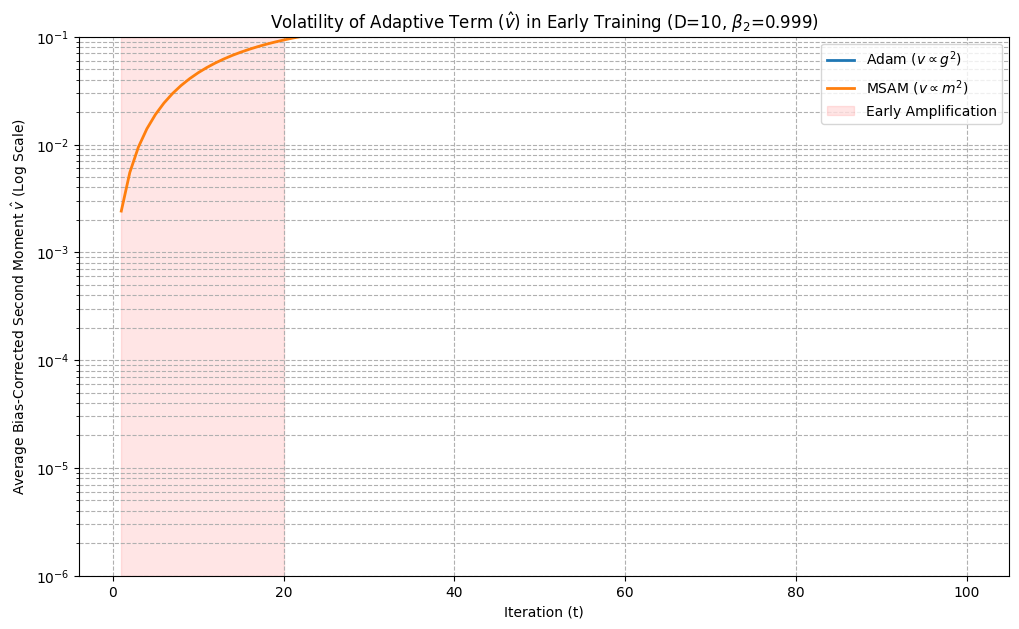

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
#   CONFIGURATION
# --------------------------
np.random.seed(42)

LR = 0.001
BETAS = (0.9, 0.999)
EPS = 1e-8
MAX_ITERS = 100

DIMENSION = 10
CONDITION_NUMBER = 10.0


# --------------------------
#   QUADRATIC PROBLEM SETUP
# --------------------------
def create_quadratic_problem(dim, condition_num):
    """Generate a symmetric positive-definite matrix Q."""
    s_max = 1.0
    s_min = s_max / condition_num

    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2  # Symmetrize

    print(f"{dim}-dimensional Q matrix with condition number: {np.linalg.cond(Q):.2f}")
    return Q


Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)
X0 = np.random.randn(DIMENSION)
print(f"Starting vector X0. Initial Loss: {0.5 * X0.T @ Q_MATRIX @ X0:.3e}")


def quadratic_gradient(x):
    return Q_MATRIX @ x


# --------------------------
#   OPTIMIZER TRACKERS
# --------------------------
def run_adam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)

    vhat_history = []

    for t in range(1, max_iters + 1):
        grad = quadratic_gradient(x)

        # Update first & second moments
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # Bias correction
        mhat = m / (1 - beta1 ** t)
        vhat = v / (1 - beta2 ** t)

        vhat_history.append(np.mean(np.abs(vhat)))

        # Update step
        x -= lr * mhat / (np.sqrt(vhat) + eps)

    return vhat_history


def run_msam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)

    vhat_history = []

    for t in range(1, max_iters + 1):
        grad = quadratic_gradient(x)

        # squared momentum instead of squared gradient
        m_new = beta1 * m + (1 - beta1) * grad
        v_new = beta2 * v + (1 - beta2) * (m_new ** 2)

        mhat = m_new / (1 - beta1 ** t)
        vhat = v_new / (1 - beta2 ** t)

        vhat_history.append(np.mean(np.abs(vhat)))

        # Update
        x -= lr * mhat / (np.sqrt(vhat) + eps)

        m, v = m_new, v_new

    return vhat_history


# --------------------------
#   EXECUTE
# --------------------------
adam_vhat_history = run_adam_tracker(X0, LR, DIMENSION, BETAS, EPS, MAX_ITERS)
msam_vhat_history = run_msam_tracker(X0, LR, DIMENSION, BETAS, EPS, MAX_ITERS)


# --------------------------
#   PLOTTING
# --------------------------
plt.figure(figsize=(12, 7))
iters = range(1, MAX_ITERS + 1)

plt.plot(iters, adam_vhat_history, label="Adam ($v \\propto g^2$)", linewidth=2)
plt.plot(iters, msam_vhat_history, label="MSAM ($v \\propto m^2$)", linewidth=2)

plt.axvspan(1, 20, color='red', alpha=0.1, label='Early Amplification')

plt.xlabel("Iteration (t)")
plt.ylabel(r"Average Bias-Corrected Second Moment $\hat{v}$ (Log Scale)")
plt.yscale("log")

plt.title(
    rf"Volatility of Adaptive Term ($\hat{{v}}$) in Early Training "
    rf"(D={DIMENSION}, $\beta_2$={BETAS[1]})"
)

plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.ylim(1e-6, 1e-1)
plt.show()


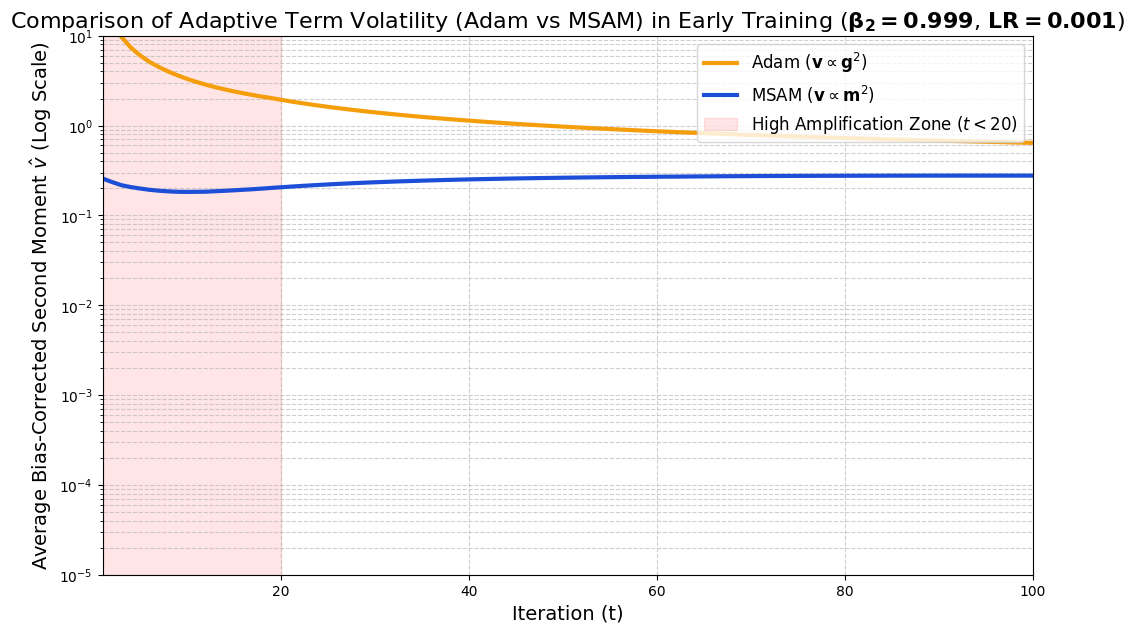

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- Configuration ---
LR = 0.001 # Corrected Learning Rate
BETAS = (0.9, 0.999) # Standard Adam/MSAM betas
EPS = 1e-8
MAX_ITERS = 100 

DIMENSION = 100
CONDITION_NUMBER = 5.0 # Ill-conditioned problem to simulate varied gradients

def create_quadratic_problem(dim, condition_num):
    """Generates a positive definite matrix Q for the quadratic function."""
    s_max = 1.0
    s_min = s_max / condition_num
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)
    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)
X0 = np.random.randn(DIMENSION)

def quadratic_gradient(x, t):
    """Calculates the gradient with added noise to simulate variance."""
    grad_true = Q_MATRIX @ x
    
    # Inject high noise only at t=1, then lower noise for instability
    if t == 1:
        # High, random noise to simulate initial poor initialization
        noise_level = 5.0 
    elif t < 20:
        # Mild noise to keep the adaptive term volatile
        noise_level = 0.5 
    else:
        # Low noise for later stability
        noise_level = 0.1
        
    # Adding Gaussian noise
    noise = np.random.randn(DIMENSION) * noise_level
    return grad_true + noise

# --- Optimizer Tracking Functions ---

def run_adam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    """Runs Adam optimization and tracks the average adaptive term (vhat)."""
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = quadratic_gradient(x, t)
        
        # 1. Update moments
        m = beta1 * m + (1.0 - beta1) * grad
        v = beta2 * v + (1.0 - beta2) * (grad**2) # Adam: uses squared gradient
        
        # 2. Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        vhat = v / denom_b2
        mhat = m / denom_b1
        
        # 3. Track L1 norm of the adaptive term (vhat)
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # 4. Perform update step (using LR=0.001)
        x -= lr * mhat / (np.sqrt(vhat) + eps)

    return vhat_history


def run_msam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    """Runs MSAM optimization and tracks the average adaptive term (vhat)."""
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = quadratic_gradient(x, t)
        
        # 1. Update moments
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # MSAM: uses squared momentum (m_new^2)
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        # 2. Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        vhat = v_new / denom_b2
        mhat = m_new / denom_b1
        
        # 3. Track L1 norm of the adaptive term (vhat)
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # 4. Perform update step (using LR=0.001)
        x -= lr * mhat / (np.sqrt(vhat) + eps)

        m = m_new
        v = v_new

    return vhat_history


# --- Execute Runs ---

adam_vhat_history = run_adam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)

msam_vhat_history = run_msam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)


# --- Plotting the Adaptive Term ---

plt.figure(figsize=(12, 7))

iters = range(1, MAX_ITERS + 1)

# Plotting the Average Bias-Corrected Second Moment (vhat)
plt.plot(iters, adam_vhat_history, 
         label='Adam ($\mathbf{v} \\propto \mathbf{g}^2$)', linewidth=3, color='#F59E0B') 
plt.plot(iters, msam_vhat_history, 
         label='MSAM ($\mathbf{v} \\propto \mathbf{m}^2$)', linewidth=3, color='#1D4ED8') 

# Highlight the initial amplification period
plt.axvspan(1, 20, color='red', alpha=0.1, label='High Amplification Zone ($t<20$)')


plt.xlabel("Iteration (t)", fontsize=14)
plt.ylabel("Average Bias-Corrected Second Moment $\\hat{v}$ (Log Scale)", fontsize=14)
plt.title(f"Comparison of Adaptive Term Volatility (Adam vs MSAM) in Early Training ($\mathbf{{\\beta_2=0.999}}$, $\mathbf{{LR=0.001}}$)", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.xlim(1, MAX_ITERS)
plt.ylim(1e-5, 1e1) 
plt.show()

Initial Loss (Rosenbrock at X0): 24.20


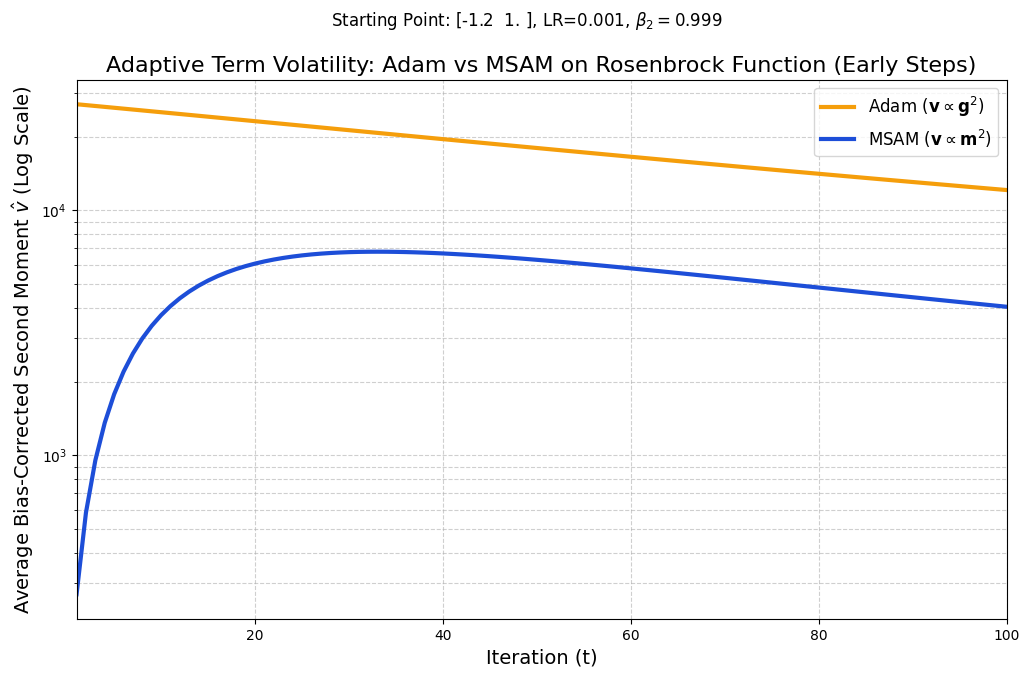

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- Configuration for Rosenbrock Optimization ---
LR = 0.001
BETAS = (0.9, 0.999) # Standard Adaptive Opt. Betas
EPS = 1e-8
MAX_ITERS = 100 # Focus on "Early training" volatility

DIMENSION = 2
X0 = np.array([-1.2, 1.0]) # Starting point for Rosenbrock function
initial_loss = (1.0 - X0[0])**2 + 100.0 * (X0[1] - X0[0]**2)**2
print(f"Initial Loss (Rosenbrock at X0): {initial_loss:.2f}")

def rosenbrock_gradient(x):
    """The gradient of the Rosenbrock function."""
    grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    grad_y = 200.0 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])


# --- Optimizer Implementations tracking Vhat ---

def run_adam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    """Runs Adam and tracks the average adaptive term (vhat)."""
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = rosenbrock_gradient(x)
        
        # 1. Update moments
        m = beta1 * m + (1.0 - beta1) * grad
        v = beta2 * v + (1.0 - beta2) * (grad**2) # Adam: uses squared gradient (g^2)
        
        # 2. Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        vhat = v / denom_b2
        mhat = m / denom_b1
        
        # 3. Track L1 norm of the adaptive term (vhat)
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # 4. Perform update step
        x -= lr * mhat / (np.sqrt(vhat) + eps)

    return vhat_history


def run_msam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    """Runs MSAM and tracks the average adaptive term (vhat)."""
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = rosenbrock_gradient(x)
        
        # 1. Update moments
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # MSAM Innovation: v is based on squared momentum (m_new^2)
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        # 2. Bias correction
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        vhat = v_new / denom_b2
        mhat = m_new / denom_b1
        
        # 3. Track L1 norm of the adaptive term (vhat)
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # 4. Perform update step
        x -= lr * mhat / (np.sqrt(vhat) + eps)

        m = m_new
        v = v_new

    return vhat_history


# --- Execute Runs ---

adam_vhat_history = run_adam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)

msam_vhat_history = run_msam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)


# --- Plotting the Adaptive Term Volatility ---

plt.figure(figsize=(12, 7))

iters = range(1, MAX_ITERS + 1)

plt.plot(iters, adam_vhat_history, 
         label='Adam ($\mathbf{v} \\propto \mathbf{g}^2$)', linewidth=3, color='#F59E0B') 
plt.plot(iters, msam_vhat_history, 
         label='MSAM ($\mathbf{v} \\propto \mathbf{m}^2$)', linewidth=3, color='#1D4ED8') 

plt.xlabel("Iteration (t)", fontsize=14)
plt.ylabel("Average Bias-Corrected Second Moment $\\hat{v}$ (Log Scale)", fontsize=14)
plt.title(f"Adaptive Term Volatility: Adam vs MSAM on Rosenbrock Function (Early Steps)", fontsize=16)
plt.suptitle(f"Starting Point: {X0}, LR={LR}, $\\beta_2={BETAS[1]}$", fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.xlim(1, MAX_ITERS)
plt.show()

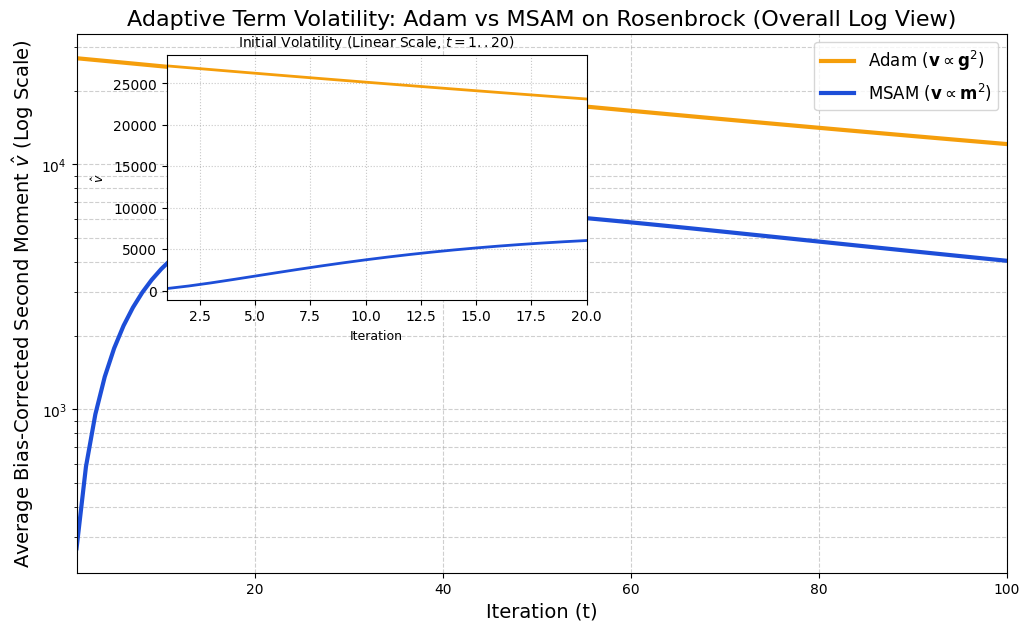

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- Configuration for Rosenbrock Optimization ---
LR = 0.001
BETAS = (0.9, 0.999) # Standard Adaptive Opt. Betas
EPS = 1e-8
MAX_ITERS = 100 # Focus on "Early training" volatility

DIMENSION = 2
X0 = np.array([-1.2, 1.0]) # Starting point for Rosenbrock function

def rosenbrock_gradient(x):
    """The gradient of the Rosenbrock function."""
    grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    grad_y = 200.0 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])


# --- Optimizer Implementations tracking Vhat (Same as before) ---

def run_adam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = rosenbrock_gradient(x)
        m = beta1 * m + (1.0 - beta1) * grad
        v = beta2 * v + (1.0 - beta2) * (grad**2) # Adam: g^2
        
        denom_b2 = 1.0 - beta2 ** t
        vhat = v / denom_b2
        
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # Update step (required to move to next gradient position)
        mhat = m / (1.0 - beta1 ** t)
        x -= lr * mhat / (np.sqrt(vhat) + eps)

    return vhat_history


def run_msam_tracker(initial_x, lr, dim, betas, eps, max_iters):
    x = initial_x.copy()
    beta1, beta2 = betas
    m = np.zeros(dim)
    v = np.zeros(dim)
    vhat_history = []
    
    for t in range(1, max_iters + 1):
        grad = rosenbrock_gradient(x)
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared # MSAM: m^2
        
        denom_b2 = 1.0 - beta2 ** t
        vhat = v_new / denom_b2
        
        vhat_history.append(np.mean(np.abs(vhat)))
        
        # Update step (required to move to next gradient position)
        mhat = m_new / (1.0 - beta1 ** t)
        x -= lr * mhat / (np.sqrt(vhat) + eps)

        m = m_new
        v = v_new

    return vhat_history


# --- Execute Runs ---
adam_vhat_history = run_adam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)

msam_vhat_history = run_msam_tracker(
    initial_x=X0, lr=LR, dim=DIMENSION, betas=BETAS, eps=EPS, max_iters=MAX_ITERS
)


# --- Plotting the Adaptive Term Volatility ---

fig, ax = plt.subplots(figsize=(12, 7))

iters = range(1, MAX_ITERS + 1)

# Main Plot: Log Scale
ax.plot(iters, adam_vhat_history, 
        label='Adam ($\mathbf{v} \\propto \mathbf{g}^2$)', linewidth=3, color='#F59E0B') 
ax.plot(iters, msam_vhat_history, 
        label='MSAM ($\mathbf{v} \\propto \mathbf{m}^2$)', linewidth=3, color='#1D4ED8') 

ax.set_xlabel("Iteration (t)", fontsize=14)
ax.set_ylabel("Average Bias-Corrected Second Moment $\\hat{v}$ (Log Scale)", fontsize=14)
ax.set_title(f"Adaptive Term Volatility: Adam vs MSAM on Rosenbrock (Overall Log View)", fontsize=16)
ax.legend(loc='upper right', fontsize=12)
ax.set_yscale('log')
ax.grid(True, which="both", ls="--", alpha=0.6)
ax.set_xlim(1, MAX_ITERS)

# --- Inset Plot: Linear Scale Zoom on Early Steps ---
# This plot clearly shows the absolute spike difference.
ax_inset = fig.add_axes([0.2, 0.5, 0.35, 0.35]) # [left, bottom, width, height]
ax_inset.plot(iters[:20], adam_vhat_history[:20], 
              linewidth=2, color='#F59E0B')
ax_inset.plot(iters[:20], msam_vhat_history[:20], 
              linewidth=2, color='#1D4ED8')

ax_inset.set_title("Initial Volatility (Linear Scale, $t=1..20$)", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=9)
ax_inset.set_ylabel("$\\hat{v}$", fontsize=9)
ax_inset.set_xlim(1, 20)
ax_inset.grid(True, ls=':', alpha=0.7)

plt.show()